# Legal Document Graph Construction and Refinement with R-GCN

## Overview

In this notebook, we build an intelligent graph representation of legal document chunks.  
The goal is to transform precomputed document embeddings into a graph structure that captures:
- **Document hierarchy**
- **Cross-document relationships**
- **Semantic similarities**

After constructing the graph, we apply a **Relational Graph Convolutional Network (R-GCN)** to:
- **Refine node representations (embeddings)**
- **Learn structural and semantic patterns**
- **Predict potential new relationships (link prediction)**

Finally, we **visualize the learned embeddings** and **analyze node clusters** to evaluate how well the GNN captures document relationships. This pipeline prepares the data for downstream applications like:
- **Semantic Search**
- **Document Recommendation**
- **Legal Question Answering Systems**


### 1. Load Precomputed Document Embeddings

We load the **hybrid-chunked legal document dataset** from a saved `.pkl` file.
This dataset includes:

- Document chunk IDs
- Metadata such as document names and categories
- **Precomputed sentence embeddings** (from a Sentence-BERT model)

These embeddings serve as the **starting point** for graph construction and GNN processing.

If needed, the raw embedding matrix can also be loaded separately from a `.npy` file.


In [3]:
import pandas as pd
import numpy as np # Good practice to import numpy if embeddings are involved

# Define the path to your saved pickle file
pickle_file_path = 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'

try:
    hybrid_chunks_df = pd.read_pickle(pickle_file_path)
    print(f"Successfully loaded 'hybrid_chunks_df' from {pickle_file_path}")
    print(f"DataFrame shape: {hybrid_chunks_df.shape}")
    
    # Verify the 'embedding' column and its contents (optional)
    if 'embedding' in hybrid_chunks_df.columns:
        print(f"First embedding type: {type(hybrid_chunks_df['embedding'].iloc[0])}")
        if isinstance(hybrid_chunks_df['embedding'].iloc[0], np.ndarray):
            print(f"First embedding shape: {hybrid_chunks_df['embedding'].iloc[0].shape}")
        elif isinstance(hybrid_chunks_df['embedding'].iloc[0], list):
            print(f"First embedding length (list): {len(hybrid_chunks_df['embedding'].iloc[0])}")
    else:
        print("Warning: 'embedding' column not found in the loaded DataFrame.")
        
    # Display the head of the loaded DataFrame
    # In a Jupyter Notebook, you can use display() for richer output
    try:
        display(hybrid_chunks_df.head())
    except NameError: # Fallback for non-Jupyter environments
        print(hybrid_chunks_df.head())

except FileNotFoundError:
    print(f"Error: The file {pickle_file_path} was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred while loading the pickle file: {e}")

# If you also need the embeddings as a separate NumPy matrix (though it's already in the DataFrame):
# npy_file_path = 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'
# try:
#     full_embeddings_matrix = np.load(npy_file_path, allow_pickle=True) # allow_pickle=True if embeddings were objects
#     print(f"\nSuccessfully loaded 'full_embeddings_matrix' from {npy_file_path}")
#     print(f"Embeddings matrix shape: {full_embeddings_matrix.shape}")
# except FileNotFoundError:
#     print(f"Error: The file {npy_file_path} was not found.")
# except Exception as e:
#     print(f"An error occurred while loading the .npy file: {e}")

Successfully loaded 'hybrid_chunks_df' from c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl
DataFrame shape: (6434, 18)
First embedding type: <class 'numpy.ndarray'>
First embedding shape: (768,)


,chunk_id,doc_id,doc_name,category,text,chunk_method,level,start_idx,end_idx,document_position,position_score,is_special_section,section_type,level_size,contained_chunks,chunk_relationships,num_words,embedding
0,0,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...,semantic,L1,0,2782,beginning,0.95,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [1, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.15306216, 0.17692535, 0.07601996, -0.44562..."
1,1,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"respect to the United States are granted to, h...",semantic,L1,2783,5586,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 2, 3, 4, 5, 6, 7, 8...",400,"[-0.030139253, 0.2850941, 0.57376814, 0.084585..."
2,2,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"animated, artistic, dramatic, sculptural, musi...",semantic,L1,5587,8324,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 3, 4, 5, 6, 7, 8...",400,"[-0.051381186, 0.17251861, 0.1538294, 0.161512..."
3,3,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,"specifically described on Exhibit A, for the T...",semantic,L1,8325,10884,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 4, 5, 6, 7, 8...",400,"[-0.09265722, 0.28968588, 0.29306132, -0.43788..."
4,4,0,AlliedEsportsEntertainmentInc_20190815_8-K_EX-...,License_Agreements,to Licensee and rights of approval of Licensor...,semantic,L1,10885,13437,beginning,0.85,True,definitions,NaN,NaN,"{'same_doc_l1_chunks': [0, 1, 2, 3, 5, 6, 7, 8...",400,"[0.056043375, 0.1772994, 0.2049528, -0.1843618..."


### 2. Graph Construction from Document Chunks

We build a **multi-relational graph** where:

- **Nodes** represent document chunks, each initialized with:
  - Document metadata
  - A snippet of the chunk’s text
  - Precomputed sentence embeddings

- **Edges** capture different relationship types:
  - **Hierarchical links** (parent-child relationships between chunk levels)
  - **Same-document links** (connecting chunks from the same document)
  - **Semantic similarity links** (added between semantically similar L1-level chunks using cosine similarity with a threshold)

Additional **degree attributes** are computed for each node to represent their structural importance.

A sample **subgraph** is also extracted for preview, focusing on one document's chunks and their relationships.


In [4]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

# Ensure hybrid_chunks_df is loaded, otherwise, this cell won't work.
if 'hybrid_chunks_df' not in locals() or hybrid_chunks_df.empty:
    print("Error: hybrid_chunks_df is not defined or is empty. Please load it first.")
    # You might want to stop execution here or load it if you have a standard loading script
    # For example:
    # try:
    #     hybrid_chunks_df = pd.read_pickle('c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl')
    #     print("Successfully loaded hybrid_chunks_df for graph construction.")
    # except FileNotFoundError:
    #     print("Failed to auto-load hybrid_chunks_df. Please ensure it's loaded before this cell.")
    #     raise # Stop execution
else:
    print(f"Using pre-loaded hybrid_chunks_df with {len(hybrid_chunks_df)} rows for graph construction.")

    # Initialize a new MultiDiGraph
    G = nx.MultiDiGraph()

    # Add nodes with attributes from hybrid_chunks_df
    for idx, row in hybrid_chunks_df.iterrows():
        # Ensure embedding is a list or 1D numpy array before adding to node
        embedding_value = row['embedding']
        if isinstance(embedding_value, np.ndarray):
            embedding_value = embedding_value.tolist() # Convert to list if it's a numpy array

        G.add_node(
            row['chunk_id'],
            doc_id=row['doc_id'],
            doc_name=row['doc_name'],
            category=row['category'],
            text=row['text'][:100] + '...' if len(row['text']) > 100 else row['text'],  # Store a snippet
            level=row['level'],
            chunk_method=row['chunk_method'],
            start_idx=row['start_idx'],
            end_idx=row['end_idx'],
            is_special_section=row.get('is_special_section', False), # Use .get for safety
            section_type=row.get('section_type', None),             # Use .get for safety
            embedding=embedding_value # Store the embedding
        )
    print(f"Added {G.number_of_nodes()} nodes to the graph.")

    # Add hierarchical and same-document edges
    edge_count = 0
    for idx, row in hybrid_chunks_df.iterrows():
        current_chunk_id = row['chunk_id']
        relationships = row.get('chunk_relationships', {}) # Use .get for safety

        # Hierarchical parent edges (L1 to L2/L3/full)
        if relationships and relationships.get('hierarchical_parents'):
            for parent_id in relationships['hierarchical_parents']:
                if G.has_node(parent_id) and G.has_node(current_chunk_id):
                    G.add_edge(current_chunk_id, parent_id, type='hierarchical_child_to_parent')
                    edge_count += 1

        # Contained chunk edges (L2/L3/full to L1)
        if row.get('contained_chunks') and isinstance(row['contained_chunks'], list):
            for child_id in row['contained_chunks']:
                if G.has_node(child_id) and G.has_node(current_chunk_id):
                    G.add_edge(current_chunk_id, child_id, type='hierarchical_parent_to_child')
                    edge_count += 1

        # Same document L1 chunk edges
        if relationships and relationships.get('same_doc_l1_chunks'):
            for same_doc_l1_id in relationships['same_doc_l1_chunks']:
                if G.has_node(same_doc_l1_id) and G.has_node(current_chunk_id):
                    # For MultiDiGraph, we don't need to check if an edge already exists
                    # if we want to allow multiple types of edges or multiple edges of the same type (though here type is fixed).
                    # If 'same_document_l1' is inherently undirected, adding one direction is fine.
                    # The PyG conversion will typically add the reverse edge.
                    G.add_edge(current_chunk_id, same_doc_l1_id, type='same_document_l1')
                    edge_count += 1

    print(f"Added {edge_count} edges from hierarchical and same-document relationships.")

    # Add semantic similarity edges (example for a subset of L1 chunks to manage computation)
    l1_chunks = hybrid_chunks_df[hybrid_chunks_df['level'] == 'L1']
    # For demonstration, let's take a small sample or chunks from a specific document
    # Ensure there are enough L1 chunks to sample from, otherwise sample all of them.
    num_l1_to_sample = min(100, len(l1_chunks))
    if num_l1_to_sample > 0:
        sample_l1_chunks = l1_chunks.sample(num_l1_to_sample, random_state=42)
    else:
        sample_l1_chunks = pd.DataFrame() # Empty DataFrame if no L1 chunks

    similarity_threshold = 0.6 # Adjust as needed
    semantic_edge_count = 0

    if not sample_l1_chunks.empty and 'embedding' in sample_l1_chunks.columns:
        # Ensure embeddings are in a format suitable for cosine_similarity (list of lists/arrays)
        embeddings_list = [np.array(emb).flatten() for emb in sample_l1_chunks['embedding'].tolist()]
        if embeddings_list:
            try:
                embeddings_sample = np.array(embeddings_list)
                if embeddings_sample.ndim == 2: # Ensure embeddings are correctly stacked
                    cosine_sim_matrix = cosine_similarity(embeddings_sample)

                    for i in range(len(sample_l1_chunks)):
                        for j in range(i + 1, len(sample_l1_chunks)): # Avoid self-loops and duplicate edges for this type
                            if cosine_sim_matrix[i, j] > similarity_threshold:
                                node1_id = sample_l1_chunks.iloc[i]['chunk_id']
                                node2_id = sample_l1_chunks.iloc[j]['chunk_id']
                                if G.has_node(node1_id) and G.has_node(node2_id):
                                    # Add directed edge. PyG conversion will add the reverse if treating as undirected.
                                    G.add_edge(node1_id, node2_id, type='semantic_similarity', weight=float(cosine_sim_matrix[i, j]))
                                    # If you want to explicitly make it undirected in NetworkX immediately:
                                    # G.add_edge(node2_id, node1_id, type='semantic_similarity', weight=float(cosine_sim_matrix[i, j]))
                                    semantic_edge_count += 1
                    print(f"Added {semantic_edge_count} semantic similarity edges (based on a sample of L1 chunks).")
                else:
                    print("Embeddings for sample L1 chunks are not in the expected 2D array format after conversion.")
            except Exception as e:
                print(f"Error processing embeddings for cosine similarity: {e}")
        else:
            print("Embedding list for sample L1 chunks is empty.")
    else:
        if sample_l1_chunks.empty:
            print("No L1 chunks found to sample for semantic similarity.")
        else:
            print("No 'embedding' column found in the sample L1 chunks or sample is empty.")


    # Calculate and add degree as a node attribute (optional, but can be useful)
    # For MultiDiGraph, G.degree() gives combined in+out degree.
    # You can choose G.in_degree() or G.out_degree() if directionality is important for this feature.
    degrees = dict(G.degree())
    nx.set_node_attributes(G, degrees, 'degree')
    print("Added 'degree' attribute to nodes.")


    print(f"Total nodes in graph: {G.number_of_nodes()}")
    print(f"Total edges in graph: {G.number_of_edges()}") # For MultiDiGraph, this counts all edges

    # Display a small part of the graph (e.g., nodes and edges related to one document)
    if not hybrid_chunks_df.empty and G.number_of_nodes() > 0:
        # Ensure there's at least one unique doc_id to sample from
        unique_doc_ids = hybrid_chunks_df['doc_id'].unique()
        if len(unique_doc_ids) > 0:
            sample_doc_id = unique_doc_ids[0] # Take the first document ID
            nodes_of_sample_doc = [node for node, data in G.nodes(data=True) if data.get('doc_id') == sample_doc_id]

            if nodes_of_sample_doc:
                subgraph_sample_doc = G.subgraph(nodes_of_sample_doc)
                print(f"Subgraph for document ID {sample_doc_id} has {subgraph_sample_doc.number_of_nodes()} nodes and {subgraph_sample_doc.number_of_edges()} edges.")
                # For a very simple text representation:
                # print("Sample edges from subgraph:")
                # for u, v, data in list(subgraph_sample_doc.edges(data=True))[:5]: # Print first 5 edges of the subgraph
                #    print(f"({u}) -> ({v}) type: {data.get('type')}")
            else:
                print(f"No nodes found for sample document ID {sample_doc_id}.")
        else:
            print("No unique document IDs found in hybrid_chunks_df to create a subgraph sample.")
    elif G.number_of_nodes() == 0:
        print("Graph is empty, cannot create subgraph sample.")
    else: # hybrid_chunks_df is empty but G might have been loaded differently
        print("hybrid_chunks_df is empty, cannot create document-specific subgraph sample.")



Using pre-loaded hybrid_chunks_df with 6434 rows for graph construction.
Added 6434 nodes to the graph.
Added 93582 edges from hierarchical and same-document relationships.
Added 4950 semantic similarity edges (based on a sample of L1 chunks).
Added 'degree' attribute to nodes.
Total nodes in graph: 6434
Total edges in graph: 98532
Subgraph for document ID 0 has 36 nodes and 278 edges.


### 3. Convert Graph to PyTorch Geometric (PyG) Data Object

To prepare the graph for **GNN-based learning**, we convert the **NetworkX graph** to a **PyG Data object**, which contains:

- **Node features (x)**:  
  Precomputed sentence embeddings from the document chunks.
  
- **Edge indices (edge_index)**:  
  Source and target node pairs representing edges.

- **Edge types (edge_type)**:  
  Encoded relationship types like:
  - Hierarchical
  - Same-document
  - Semantic similarity

- **Edge attributes (edge_attr)**:  
  Additional edge-level features such as **similarity scores**.

- **Node Labels (y)**:  
  Document category labels for **node classification tasks** (optional).

The resulting `pyg_data` object is now **ready for training** using **Relational Graph Convolutional Networks (R-GCN)** or other GNN models.


In [5]:
# Cell: Convert NetworkX graph to PyG Data object

import torch
import numpy as np
import pandas as pd # Used for optional category processing
from torch_geometric.data import Data

# Ensure G is available from the previous cell and hybrid_chunks_df might be needed for some attributes
if 'G' not in locals():
    print("Error: NetworkX graph G is not defined. Please run the graph construction cell first.")
    # To stop execution if G is not found, you can uncomment the next line:
    # raise NameError("NetworkX graph G not found. Please run the previous cell.")
    pyg_data = None # Or handle error as preferred
else:
    print(f"Starting conversion of NetworkX graph G (Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}) to PyG Data object.")

    # 1. Define edge type mapping to integers
    # These types should match exactly those used when creating edges in G
    edge_type_to_int = {
        'hierarchical_child_to_parent': 0,
        'hierarchical_parent_to_child': 1,
        'same_document_l1': 2,
        'semantic_similarity': 3
        # Add any other custom edge types if you have them
    }
    num_relations = len(edge_type_to_int)
    print(f"Defined {num_relations} edge types: {edge_type_to_int}")

    # 2. Create node mapping (original chunk_id to integer index for PyG)
    # Sorting nodes ensures a consistent order for features and mappings
    if G.number_of_nodes() > 0:
        sorted_nodes = sorted(list(G.nodes()))
        node_to_int_mapping = {node_id: i for i, node_id in enumerate(sorted_nodes)}
        int_to_node_id_mapping = {i: node_id for node_id, i in node_to_int_mapping.items()}
    else:
        sorted_nodes = []
        node_to_int_mapping = {}
        int_to_node_id_mapping = {}
    print(f"Created mapping for {len(sorted_nodes)} nodes.")

    # 3. Extract node features (x - embeddings)
    embedding_dim = None
    # Try to determine embedding_dim from hybrid_chunks_df first, then from G
    if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty and 'embedding' in hybrid_chunks_df.columns:
        for emb_val in hybrid_chunks_df['embedding']:
            if emb_val is not None:
                if isinstance(emb_val, np.ndarray):
                    embedding_dim = emb_val.shape[0]
                    break
                elif isinstance(emb_val, list):
                    embedding_dim = len(emb_val)
                    break
    
    if embedding_dim is None and G.number_of_nodes() > 0:
        for node_id_example in sorted_nodes: # Iterate through sorted_nodes
            emb_attr = G.nodes[node_id_example].get('embedding')
            if emb_attr is not None:
                if isinstance(emb_attr, np.ndarray):
                    embedding_dim = emb_attr.shape[0] if emb_attr.ndim == 1 else emb_attr.shape[-1] # Handle flattened or original
                    break
                elif isinstance(emb_attr, list):
                    embedding_dim = len(emb_attr)
                    break
    
    if embedding_dim is None:
        if G.number_of_nodes() > 0 :
             print("Warning: Could not auto-determine embedding dimension. Will try to infer from first valid embedding.")
        else:
             print("Graph has no nodes, embedding dimension not determined yet.")
             embedding_dim = 1 # Placeholder if graph is truly empty and no df info

    node_features_list = []
    if G.number_of_nodes() > 0:
        first_valid_embedding_dim_found = False
        for i in range(len(sorted_nodes)):
            node_id = int_to_node_id_mapping[i]
            embedding = G.nodes[node_id].get('embedding')
            
            current_embedding_vector = None
            if embedding is not None:
                if isinstance(embedding, np.ndarray):
                    current_embedding_vector = embedding.flatten().tolist()
                elif isinstance(embedding, list):
                    current_embedding_vector = embedding
                else:
                    print(f"Warning: Node {node_id} embedding is of unexpected type {type(embedding)}.")

                if current_embedding_vector is not None:
                    if embedding_dim is None and not first_valid_embedding_dim_found: # Infer dim from first valid
                        embedding_dim = len(current_embedding_vector)
                        first_valid_embedding_dim_found = True
                        print(f"Inferred embedding dimension as {embedding_dim} from node {node_id}.")
                    
                    if embedding_dim is not None and len(current_embedding_vector) != embedding_dim:
                        print(f"Warning: Node {node_id} embedding dim {len(current_embedding_vector)} != expected {embedding_dim}. Using zero vector.")
                        current_embedding_vector = [0.0] * embedding_dim
            
            if current_embedding_vector is None: # If embedding was None or became None
                if embedding_dim is None: # Should not happen if nodes exist and one has embedding
                    print(f"Critical: Node {node_id} has no embedding and dimension is still unknown. Defaulting dim to 100 for this node.")
                    current_embedding_vector = [0.0] * 100
                else:
                    # print(f"Info: Node {node_id} has no valid embedding. Using zero vector of dim {embedding_dim}.")
                    current_embedding_vector = [0.0] * embedding_dim
            
            node_features_list.append(current_embedding_vector)

    if embedding_dim is None and G.number_of_nodes() > 0: # If still None after iterating all nodes
        print("CRITICAL WARNING: Embedding dimension could not be determined even after checking all nodes. Defaulting to 100.")
        embedding_dim = 100
        # Retroactively fix any zero vectors if node_features_list was populated with a wrong temp dim
        if node_features_list and len(node_features_list[0]) != embedding_dim:
            print("Re-adjusting zero vectors to new default dimension.")
            node_features_list = [[0.0] * embedding_dim for _ in node_features_list]


    if G.number_of_nodes() == 0:
        node_features_tensor = torch.empty((0, embedding_dim if embedding_dim is not None else 1), dtype=torch.float)
    elif not node_features_list: # Should not happen if G has nodes
        print("Error: node_features_list is empty despite graph having nodes. Creating zero tensor.")
        node_features_tensor = torch.zeros((G.number_of_nodes(), embedding_dim if embedding_dim is not None else 1), dtype=torch.float)
    else:
        try:
            node_features_tensor = torch.tensor(node_features_list, dtype=torch.float)
            if node_features_tensor.shape[0] != G.number_of_nodes():
                 print(f"Warning: Node features tensor rows ({node_features_tensor.shape[0]}) != num graph nodes ({G.number_of_nodes()}).")
            if embedding_dim is not None and node_features_tensor.nelement() > 0 and node_features_tensor.shape[1] != embedding_dim:
                 print(f"Warning: Node features tensor dim ({node_features_tensor.shape[1]}) != determined embedding_dim ({embedding_dim}).")
        except Exception as e:
            print(f"Error creating node_features_tensor: {e}. Check uniformity of embedding lengths.")
            # Fallback: create a zero tensor
            node_features_tensor = torch.zeros((G.number_of_nodes(), embedding_dim if embedding_dim is not None else 1), dtype=torch.float)

    print(f"Node features (x) tensor created with shape: {node_features_tensor.shape}")

    # 4. Extract edge_index, edge_type, and edge_attr
    edge_sources = []
    edge_targets = []
    edge_type_list = []
    edge_attr_list = [] # For edge weights, e.g., from semantic similarity

    if G.number_of_edges() > 0:
        for u, v, data in G.edges(data=True):
            # Ensure nodes are in our mapping (they should be if G.nodes() was used for mapping)
            if u not in node_to_int_mapping or v not in node_to_int_mapping:
                print(f"Warning: Edge ({u}, {v}) involves node IDs not in mapping. Skipping.")
                continue

            edge_sources.append(node_to_int_mapping[u])
            edge_targets.append(node_to_int_mapping[v])
            
            edge_type_str = data.get('type')
            if edge_type_str in edge_type_to_int:
                edge_type_list.append(edge_type_to_int[edge_type_str])
            else:
                print(f"Warning: Unknown edge type '{edge_type_str}' for edge ({u}, {v}). Assigning -1 (or handle as error/default).")
                edge_type_list.append(-1) # Placeholder for unknown type

            # Handle edge attributes (like 'weight')
            # PyG expects edge_attr to be [num_edges, num_edge_features]
            if edge_type_str == 'semantic_similarity':
                edge_attr_list.append([float(data.get('weight', 1.0))])
            else:
                edge_attr_list.append([1.0]) # Default weight/attribute for other types
    
    if not edge_sources: # No edges or all edges skipped
        edge_index_tensor = torch.empty((2, 0), dtype=torch.long)
        edge_type_tensor = torch.empty((0,), dtype=torch.long)
        edge_attr_tensor = torch.empty((0, 1), dtype=torch.float) # Assuming 1 edge feature
    else:
        edge_index_tensor = torch.tensor([edge_sources, edge_targets], dtype=torch.long)
        edge_type_tensor = torch.tensor(edge_type_list, dtype=torch.long)
        edge_attr_tensor = torch.tensor(edge_attr_list, dtype=torch.float)
    
    print(f"Edge index tensor created with shape: {edge_index_tensor.shape}")
    print(f"Edge type tensor created with shape: {edge_type_tensor.shape}")
    print(f"Edge attributes tensor created with shape: {edge_attr_tensor.shape}")

    # 5. Create PyG Data object
    pyg_data = Data(x=node_features_tensor,
                    edge_index=edge_index_tensor,
                    edge_type=edge_type_tensor,
                    edge_attr=edge_attr_tensor) # Add edge_attr for weights

    # Store useful metadata in the Data object
    pyg_data.num_relations = num_relations
    pyg_data.edge_type_mapping = edge_type_to_int
    pyg_data.node_id_mapping = node_to_int_mapping # Original chunk_id to PyG integer index
    pyg_data.int_to_node_id_mapping = int_to_node_id_mapping # PyG integer index to original chunk_id
    if G.number_of_nodes() > 0:
         pyg_data.chunk_ids_ordered = sorted_nodes # Original chunk_ids in PyG node order

    # Optional: Add other node attributes like category as 'y' (target labels)
    if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty and G.number_of_nodes() > 0:
        try:
            # Align hybrid_chunks_df with the sorted_nodes order for consistent labeling
            # Ensure 'chunk_id' is the index for easy .loc access
            if 'chunk_id' not in hybrid_chunks_df.columns:
                 print("Warning: 'chunk_id' not in hybrid_chunks_df columns, cannot add category labels.")
            else:
                df_for_labels = hybrid_chunks_df.set_index('chunk_id')
                # Filter for nodes present in the graph and maintain their order
                aligned_labels_df = df_for_labels.loc[sorted_nodes]

                if 'category' in aligned_labels_df.columns:
                    unique_categories = aligned_labels_df['category'].astype('category')
                    pyg_data.y = torch.tensor(unique_categories.cat.codes.values, dtype=torch.long)
                    pyg_data.category_mapping = dict(enumerate(unique_categories.cat.categories))
                    print(f"Added 'y' (category labels) and 'category_mapping' to pyg_data. Shape: {pyg_data.y.shape}")
                
                # You can add other attributes similarly:
                # pyg_data.doc_ids = aligned_labels_df['doc_id'].tolist() # Example
        except KeyError as e:
            print(f"KeyError accessing hybrid_chunks_df for labels (some chunk_ids in graph might be missing in df): {e}")
        except Exception as e:
            print(f"An error occurred while adding attributes from hybrid_chunks_df: {e}")


    print("\n--- PyG Data object created ---")
    print(pyg_data)
    if pyg_data is not None:
        print(f"  Number of nodes: {pyg_data.num_nodes}")
        print(f"  Number of node features: {pyg_data.num_node_features}")
        print(f"  Number of edges: {pyg_data.num_edges}")
        if pyg_data.num_edges > 0 :
            print(f"  Edge index shape: {pyg_data.edge_index.shape}")
            print(f"  Edge type shape: {pyg_data.edge_type.shape}")
            print(f"  Edge attr shape: {pyg_data.edge_attr.shape}")
        print(f"  Number of relations: {pyg_data.num_relations}")
        if hasattr(pyg_data, 'y'):
            print(f"  Target 'y' shape: {pyg_data.y.shape}")
        print(f"  Contains isolated nodes: {pyg_data.has_isolated_nodes() if pyg_data.num_nodes > 0 else 'N/A'}")
        print(f"  Contains self-loops: {pyg_data.has_self_loops() if pyg_data.num_nodes > 0 else 'N/A'}")
        print(f"  Is directed: {pyg_data.is_directed() if pyg_data.num_nodes > 0 else 'N/A'}")

# Now `pyg_data` should be ready for your GNN model.
# You can access its components like:
# pyg_data.x (node features)
# pyg_data.edge_index
# pyg_data.edge_type
# pyg_data.edge_attr
# pyg_data.num_relations
# pyg_data.y (if categories were added)

c:\Conda_Environment\envs\docquery\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting conversion of NetworkX graph G (Nodes: 6434, Edges: 98532) to PyG Data object.
Defined 4 edge types: {'hierarchical_child_to_parent': 0, 'hierarchical_parent_to_child': 1, 'same_document_l1': 2, 'semantic_similarity': 3}
Created mapping for 6434 nodes.
Node features (x) tensor created with shape: torch.Size([6434, 768])
Edge index tensor created with shape: torch.Size([2, 98532])
Edge type tensor created with shape: torch.Size([98532])
Edge attributes tensor created with shape: torch.Size([98532, 1])
Added 'y' (category labels) and 'category_mapping' to pyg_data. Shape: torch.Size([6434])

--- PyG Data object created ---
Data(
  x=[6434, 768],
  edge_index=[2, 98532],
  edge_attr=[98532, 1],
  edge_type=[98532],
  num_relations=4,
  edge_type_mapping={
    hierarchical_child_to_parent=0,
    hierarchical_parent_to_child=1,
    same_document_l1=2,
    semantic_similarity=3,
  },
  node_id_mapping={
    0=0,
    1=1,
    2=2,
    3=3,
    4=4,
    5=5,
    6=6,
    7=7,
    8=8,

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import numpy as np

# Ensure pyg_data is loaded from the previous cell (f712cba0)
if 'pyg_data' not in locals():
    raise NameError("pyg_data is not defined. Please run the PyG data preparation cell (f712cba0) first.")
if 'edge_type_to_int' not in locals():
    raise NameError("edge_type_to_int is not defined. Please ensure the PyG data preparation cell (f712cba0) ran correctly.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move data to device
pyg_data = pyg_data.to(device)

# Determine the number of relations
num_relations = len(edge_type_to_int)
print(f"Number of relations: {num_relations}")
print(f"Number of node features: {pyg_data.num_node_features}")

Using device: cpu
Number of relations: 4
Number of node features: 768


### 4. Define Relational Graph Convolutional Network (R-GCN) Encoder

We define the **Relational Graph Convolutional Network (R-GCN)** architecture to process our multi-relational legal document graph.

### Why R-GCN?

- **Relational Awareness**:  
  Unlike standard GCNs, R-GCN can **differentiate between edge types**, making it ideal for our graph which contains:
  - Hierarchical edges
  - Same-document edges
  - Semantic similarity edges

- **Parameter Efficiency with Basis Decomposition**:  
  Supports **basis decomposition**, allowing the model to **scale efficiently** even with multiple relation types.

### Model Architecture

- **Input Layer**:  
  Takes precomputed sentence embeddings as **node features**.
  
- **Two R-GCN Layers**:  
  - **First layer** expands to a higher-dimensional **hidden space**.
  - **Second layer** produces **final node embeddings** for downstream tasks.

The model is now instantiated with:
- **Input features**: Dimensionality of precomputed embeddings
- **Hidden dimension**: 128 units
- **Output dimension**: 64 units
- **Relation types**: Matching the number of edge types in our graph


In [7]:
class RGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, num_bases=None):
        super().__init__()
        # If num_bases is None, it defaults to num_relations (no basis decomposition)
        # Using num_bases can reduce parameters if num_relations is very high.
        # For a moderate number of relations, you might not need it or can set it to a fraction of num_relations.
        if num_bases is None:
            num_bases = num_relations # Or set to a specific number like 30 if you have many relations

        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations, num_bases=num_bases)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations, num_bases=num_bases)
        # self.dropout = torch.nn.Dropout(0.5) # Optional dropout

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        # x = self.dropout(x) # Optional
        x = self.conv2(x, edge_index, edge_type)
        return x

# Example: Define model parameters
in_channels = pyg_data.num_node_features
hidden_channels = 128  # You can tune this
out_channels = 64    # Desired output embedding dimension, tune this

# Instantiate the encoder
rgcn_encoder = RGCNEncoder(in_channels, hidden_channels, out_channels, num_relations).to(device)
print("RGCN Encoder model defined and instantiated:")
print(rgcn_encoder)

RGCN Encoder model defined and instantiated:
RGCNEncoder(
  (conv1): RGCNConv(768, 128, num_relations=4)
  (conv2): RGCNConv(128, 64, num_relations=4)
)


### 5. Wrap R-GCN in a Graph AutoEncoder (GAE) and Prepare Training Splits

We wrap the R-GCN encoder inside a **Graph AutoEncoder (GAE)** framework provided by **PyTorch Geometric**.  
The GAE learns to **reconstruct edges** by:
- Encoding node features and structure into embeddings
- Decoding edges using the **dot product** of node embeddings

### Link Prediction Setup
The goal is to **predict missing or potential links** in the graph by optimizing reconstruction accuracy.

### Data Splitting
We split the graph's edges into:
- **Training edges** (used to learn embeddings)
- **Validation edges** (used to tune and monitor performance)
- **Test edges** (used to evaluate generalization)

PyG’s `train_test_split_edges()` handles this by:
- Generating **positive** and **negative** edge samples
- Creating dedicated edge sets for **training**, **validation**, and **testing**

The prepared data is now **ready for GAE training**.


In [8]:
# The GAE model from PyG takes an encoder.
# The decoder is implicitly a dot product of node embeddings for link prediction.
model = GAE(rgcn_encoder).to(device)
print("\nGAE model with RGCN encoder defined:")
print(model)

# Prepare data for GAE (it internally handles negative sampling for training)
# We need to split edges into training, validation, and test sets.
# PyG's train_test_split_edges modifies the data object in place to have
# train_pos_edge_index, val_pos_edge_index, test_pos_edge_index etc.
# It also adds train_neg_adj_mask, val_neg_adj_mask, test_neg_adj_mask

# Make a copy of the data to avoid modifying the original pyg_data if you need it later
data_for_gae = pyg_data.clone()
data_for_gae = train_test_split_edges(data_for_gae, val_ratio=0.1, test_ratio=0.1)
data_for_gae = data_for_gae.to(device) # Ensure it's on the device

print("\nData prepared for GAE training (edges split):")
print(data_for_gae)


GAE model with RGCN encoder defined:
GAE(
  (encoder): RGCNEncoder(
    (conv1): RGCNConv(768, 128, num_relations=4)
    (conv2): RGCNConv(128, 64, num_relations=4)
  )
  (decoder): InnerProductDecoder()
)


c:\Conda_Environment\envs\docquery\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)



Data prepared for GAE training (edges split):
Data(
  x=[6434, 768],
  edge_type=[98532],
  num_relations=4,
  edge_type_mapping={
    hierarchical_child_to_parent=0,
    hierarchical_parent_to_child=1,
    same_document_l1=2,
    semantic_similarity=3,
  },
  node_id_mapping={
    0=0,
    1=1,
    2=2,
    3=3,
    4=4,
    5=5,
    6=6,
    7=7,
    8=8,
    9=9,
    10=10,
    11=11,
    12=12,
    13=13,
    14=14,
    15=15,
    16=16,
    17=17,
    18=18,
    19=19,
    20=20,
    21=21,
    22=22,
    23=23,
    24=24,
    25=25,
    26=26,
    27=27,
    28=28,
    29=29,
    30=30,
    31=31,
    32=32,
    33=33,
    34=34,
    35=35,
    36=36,
    37=37,
    38=38,
    39=39,
    40=40,
    41=41,
    42=42,
    43=43,
    44=44,
    45=45,
    46=46,
    47=47,
    48=48,
    49=49,
    50=50,
    51=51,
    52=52,
    53=53,
    54=54,
    55=55,
    56=56,
    57=57,
    58=58,
    59=59,
    60=60,
    61=61,
    62=62,
    63=63,
    64=64,
    65=65,
    66=66,
   

### 6. Train the R-GCN with Link Prediction Objective

### Training Setup
We define:
- An **Adam optimizer** with a learning rate of **0.01**.
- A **training loop** that:
  - **Encodes** node embeddings using the R-GCN.
  - **Computes reconstruction loss** based on the ability to predict **training edges**.
  - **Normalizes the loss** to improve interpretability.
  - **Backpropagates** and updates the model weights.

### Validation Setup
A **test function** evaluates:
- **Validation AUC (Area Under ROC Curve)**: Measures ranking quality of positive vs. negative links.
- **Validation AP (Average Precision)**: Measures precision-recall balance.

### Execution
The model is trained for **200 epochs**, tracking:
- **Training loss**
- **Validation AUC**
- **Validation AP**

### Final Evaluation
After training, the model is **evaluated on the test set** to report:
- **Test AUC**
- **Test AP**

These metrics reflect the model's ability to **generalize link prediction** beyond the training data.


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(
        data_for_gae.x,
        data_for_gae.train_pos_edge_index,
        data_for_gae.edge_type[:data_for_gae.train_pos_edge_index.size(1)]
    )

    # Original summed loss
    loss = model.recon_loss(z, data_for_gae.train_pos_edge_index)

    # Normalize by number of positive edges
    num_pos_edges = data_for_gae.train_pos_edge_index.size(1)
    loss = loss / num_pos_edges

    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(pos_edge_index, neg_edge_index): # Pass edge_type for the specific set if needed
    model.eval()
    z = model.encode(data_for_gae.x, data_for_gae.train_pos_edge_index, data_for_gae.edge_type[:data_for_gae.train_pos_edge_index.size(1)]) # Use train edges for encoding
    
    # Note: The edge_type passed to encode should ideally correspond to the edges used for message passing.
    # For evaluation, we are interested in the quality of embeddings 'z' to predict links.
    # The test function in GAE computes AUC and AP scores.
    # It needs positive edges and negative edges for the set being tested.
    return model.test(z, pos_edge_index, neg_edge_index)

print("Optimizer and training/test functions defined.")

Optimizer and training/test functions defined.


In [10]:
import matplotlib.pyplot as plt

# History storage
losses = []
val_aucs = []
val_aps = []

epochs = 200  # Reuse your epoch count
for epoch in range(1, epochs + 1):
    loss = train()
    val_auc, val_ap = test(data_for_gae.val_pos_edge_index, data_for_gae.val_neg_edge_index)

    losses.append(loss)
    val_aucs.append(val_auc)
    val_aps.append(val_ap)

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


# Test set evaluation
test_auc, test_ap = test(data_for_gae.test_pos_edge_index, data_for_gae.test_neg_edge_index)
print(f'\nTest AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

Epoch: 001, Loss: 0.0003, Val AUC: 0.5198, Val AP: 0.5101
Epoch: 010, Loss: 0.0004, Val AUC: 0.5749, Val AP: 0.5406
Epoch: 020, Loss: 0.0004, Val AUC: 0.5743, Val AP: 0.5402
Epoch: 030, Loss: 0.0003, Val AUC: 0.5933, Val AP: 0.5516
Epoch: 040, Loss: 0.0003, Val AUC: 0.6732, Val AP: 0.6065
Epoch: 050, Loss: 0.0002, Val AUC: 0.7182, Val AP: 0.6418
Epoch: 060, Loss: 0.0002, Val AUC: 0.7168, Val AP: 0.6406
Epoch: 070, Loss: 0.0002, Val AUC: 0.7159, Val AP: 0.6398
Epoch: 080, Loss: 0.0002, Val AUC: 0.7197, Val AP: 0.6426
Epoch: 090, Loss: 0.0002, Val AUC: 0.7226, Val AP: 0.6450
Epoch: 100, Loss: 0.0002, Val AUC: 0.7334, Val AP: 0.6543
Epoch: 110, Loss: 0.0002, Val AUC: 0.7321, Val AP: 0.6536
Epoch: 120, Loss: 0.0002, Val AUC: 0.7389, Val AP: 0.6600
Epoch: 130, Loss: 0.0002, Val AUC: 0.7382, Val AP: 0.6594
Epoch: 140, Loss: 0.0002, Val AUC: 0.7426, Val AP: 0.6643
Epoch: 150, Loss: 0.0002, Val AUC: 0.7250, Val AP: 0.6469
Epoch: 160, Loss: 0.0002, Val AUC: 0.7352, Val AP: 0.6559
Epoch: 170, Lo

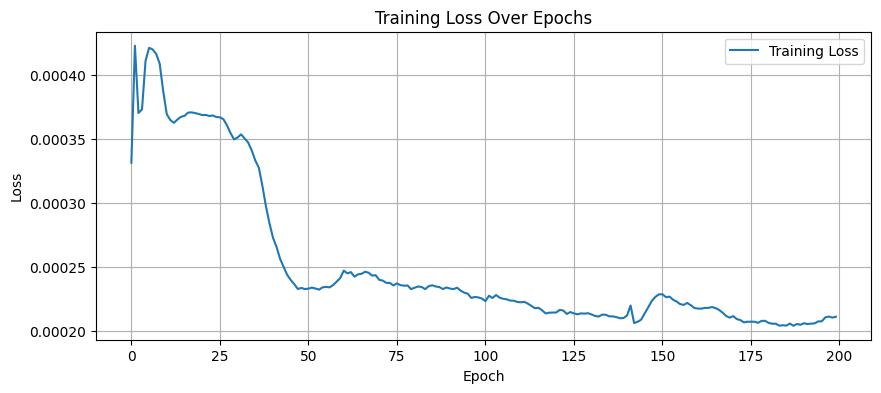

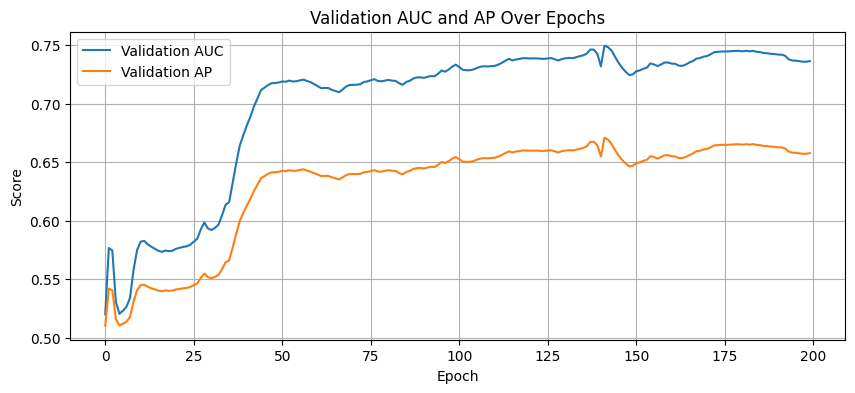

In [11]:
# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation AUC and AP
plt.figure(figsize=(10, 4))
plt.plot(val_aucs, label='Validation AUC')
plt.plot(val_aps, label='Validation AP')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation AUC and AP Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Save model parameters
torch.save(model.state_dict(), 'rgcn_gae_model.pth')
print("Model saved to 'rgcn_gae_model.pth'")

# Extract embeddings again to ensure they're fresh
model.eval()
with torch.no_grad():
    final_node_embeddings = model.encode(pyg_data.x, pyg_data.edge_index, pyg_data.edge_type)

# Save embeddings as numpy file
np.save('final_node_embeddings.npy', final_node_embeddings.cpu().numpy())
print("Final node embeddings saved to 'final_node_embeddings.npy'")


Model saved to 'rgcn_gae_model.pth'
Final node embeddings saved to 'final_node_embeddings.npy'


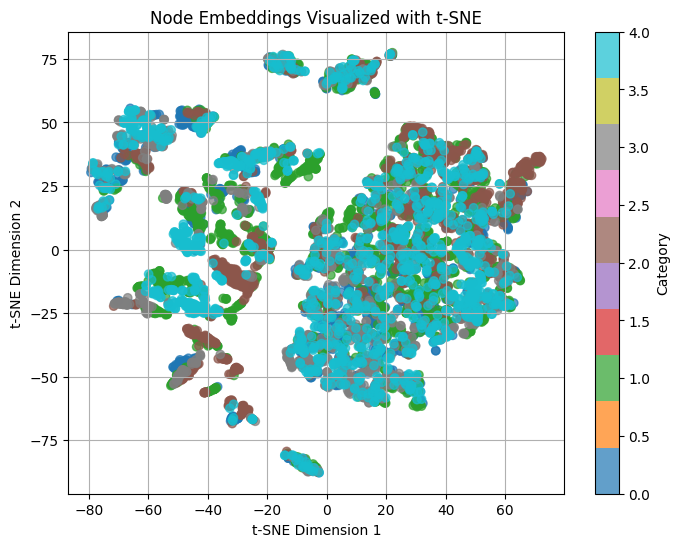

In [13]:
from sklearn.manifold import TSNE

# Convert embeddings to CPU numpy array
embeddings_np = final_node_embeddings.cpu().numpy()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(embeddings_np)

# Optional: Color by category if available
if hasattr(pyg_data, 'y'):
    labels = pyg_data.y.cpu().numpy()
else:
    labels = None

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
if labels is not None:
    plt.colorbar(scatter, label='Category')
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()


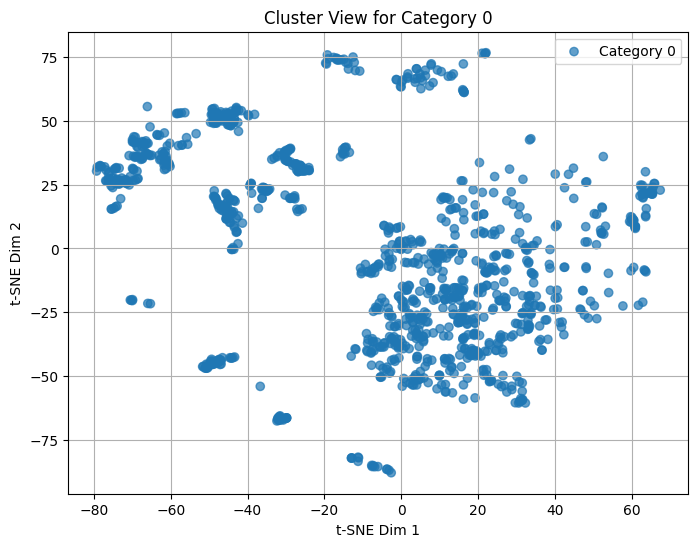

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have embeddings and category labels
embeddings_np = final_node_embeddings.cpu().numpy()
labels = pyg_data.y.cpu().numpy()  # Category labels

# Reduce dimensionality with t-SNE (if not already done)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Pick one category (e.g., category 0)
target_category = 0
mask = labels == target_category

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=labels[mask], cmap='tab10', label=f'Category {target_category}', alpha=0.7)
plt.title(f'Cluster View for Category {target_category}')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True)
plt.show()
